### my own implementation of the cnn 

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from six.moves import cPickle as pickle
from six.moves import range
%matplotlib inline

In [2]:
def init_weight_and_bias(M1,M2):
    W = np.random.randn(M1,M2) / np.sqrt(M1 + M2)
    b = np.zeros(M2)
    return W.astype(np.float32), b.astype(np.float32)

In [3]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

In [4]:
def reformat(dataset, labels):
    dataset = dataset.reshape(
        (-1, image_size, image_size, num_channels)).astype(np.float32)
    labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
    return dataset, labels

In [5]:
class HiddenLayer(object):
    def __init__(self,M1,M2,an_id):
        self.id = an_id
        self.M1 = M1
        self.M2 = M2
        W,b = init_weight_and_bias(M1,M2)
        self.W = tf.Variable(W)
        self.b = tf.Variable(b)
        self.params = [self.W,self.b]
    def forward(self,X):
        return tf.nn.relu(tf.matmul(X,self.W) + self.b)
        

In [6]:
class ConvPoolLayer(object):
    def __init__(self,mi,mo,fw=5,fh=5,poolsz=(2,2),padding='SAME'):
        self.W = tf.Variable(tf.truncated_normal([fw,fh,mi,mo],stddev=0.1))
        self.b = tf.Variable(tf.zeros([mo]))
        self.poolsz = poolsz
        self.params = [self.W,self.b]
        self.padding = padding
    def forward(self,X,strides=[1,1,1,1]):
        conv_out = tf.nn.conv2d(X,self.W,strides=strides,padding='SAME')
        conv_out = tf.nn.bias_add(conv_out,self.b)
        p1,p2 = self.poolsz
        pool_out = tf.nn.max_pool(
            conv_out,
            ksize = [1,p1,p2,1],
            strides = [1,p1,p2,1],
            padding = self.padding
        )
        return tf.nn.relu(pool_out)

In [7]:
class CNN(object):
    def __init__(self,convpool_layer_sizes,hidden_layer_sizes):
        self.convpool_layer_sizes = convpool_layer_sizes
        self.hidden_layer_sizes = hidden_layer_sizes
        
    def train(self,X,Y,X_valid = None,Y_valid = None, lr=10e-4, mu=0.99, reg=10e-4, decay=0.99999, eps=10e-3, batch_sz=30, epochs=3, show_fig=True):
        #convert hyper-parameter to np.float32
        lr = np.float32(lr)
        mu = np.float32(mu)
        reg = np.float32(reg)
        decay = np.float32(decay)
        eps = np.float32(eps)
        K = 10
        X, Y = shuffle(X, Y)
        X = X.astype(np.float32)
        Y = Y.astype(np.float32)
        # initialize convpool layers
        N,w,h,c = X.shape
        mi = c
        outw = w
        outh = h
        self.convpool_layers = []
        for mo,fw,fh in self.convpool_layer_sizes:
            layer = ConvPoolLayer(mi,mo,fw,fh)
            mi = mo 
            outw = outw / 2
            outh = outh / 2
            self.convpool_layers.append(layer)
        self.hidden_layers = []
        M1 = self.convpool_layer_sizes[-1][0]*outw*outh
        count = 0
        for M2 in self.hidden_layer_sizes:
            hidden = HiddenLayer(M1,M2,count)
            self.hidden_layers.append(hidden)
            M1 = M2
            count += 1
        #logistic regression layer
        W,b = init_weight_and_bias(M1,K)
        self.W = tf.Variable(W,'W_logreg')
        self.b = tf.Variable(b,'b_logreg')
        self.params = [self.W,self.b]
        for c_layer in self.convpool_layers:
            self.params += c_layer.params
        for h_layer in self.hidden_layers:
            self.params += h_layer.params
        #set up variables for tensorflow
        tf_X_train = tf.placeholder(tf.float32,shape=(None,w,h,c))
        tf_Y_train = tf.placeholder(tf.float32,shape=(None,K))
        logits = self.forward(tf_X_train)
        r_cost = reg*np.sum([tf.nn.l2_loss(p) for p in self.params])
        cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_Y_train,logits=logits))
        loss = cost + r_cost
        prediction = self.predict(tf_X_train)
        train_op = tf.train.RMSPropOptimizer(lr, decay=decay, momentum=mu).minimize(loss)
        n_batches = N / batch_sz
        train_costs = []
        valid_costs = []
        init = tf.global_variables_initializer()
        with tf.Session() as session:
            session.run(init)
            for epoch in xrange(epochs):
                X,Y = shuffle(X,Y)
                for j in xrange(n_batches):
                    X_batch = X[j*batch_sz: (j*batch_sz + batch_sz)]
                    Y_batch = Y[j*batch_sz: (j*batch_sz + batch_sz)]
                    session.run(train_op,feed_dict={tf_X_train:X_batch,tf_Y_train:Y_batch})
                    if j % 100 == 0:
                        if Y_valid != None:
                            print("calculating valid cost:")
                            vc = session.run(cost, feed_dict={tf_X_train: X_valid, tf_Y_train: Y_valid})
                            valid_costs.append(vc)
                            pv = session.run(prediction, feed_dict={tf_X_train: X_valid, tf_Y_train: Y_valid})
                            va = accuracy(pv,Y_valid)
                        print("calculating training cost:")
                        tc = session.run(loss, feed_dict={tf_X_train: X_batch, tf_Y_train: Y_batch})
                        train_costs.append(tc)
                        pt = session.run(prediction, feed_dict={tf_X_train: X_batch, tf_Y_train: Y_batch})
                        ta = accuracy(pt,Y_batch)
                        print "epoach:", epoch, "batch:", j, "nb:", n_batches
                        if Y_valid != None:
                            print "validation cost:", vc, "validation accuracy:", va
                        print "training cost:", tc, "training accuracy:", ta
        if show_fig:
            plt.plot(train_costs)
            plt.plot(valid_costs)
            plt.show()
    def forward(self,X):
        Z = X
        for c in self.convpool_layers:
            Z = c.forward(Z)
        #fully connected layer 
        Z_shape = Z.get_shape().as_list()
        Z = tf.reshape(Z, [-1, np.prod(Z_shape[1:])])
        for h in self.hidden_layers:
            Z = h.forward(Z)
        return tf.matmul(Z,self.W) + self.b
    def predict(self,X):
        logits = self.forward(X)
        return tf.nn.softmax(logits)

In [8]:
pickle_file = 'notMNIST.pickle'
with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_dataset = save['train_dataset']
    train_labels = save['train_labels']
    valid_dataset = save['valid_dataset']
    valid_labels = save['valid_labels']
    test_dataset = save['test_dataset']
    test_labels = save['test_labels']
    del save  # hint to help gc free up memory
    print('Training set', train_dataset.shape, train_labels.shape)
    print('Validation set', valid_dataset.shape, valid_labels.shape)
    print('Test set', test_dataset.shape, test_labels.shape)

('Training set', (200000, 28, 28), (200000,))
('Validation set', (10000, 28, 28), (10000,))
('Test set', (10000, 28, 28), (10000,))


In [9]:
image_size = 28
num_labels = 10
num_channels = 1 # grayscale

import numpy as np

def reformat(dataset, labels):
    dataset = dataset.reshape(
    (-1, image_size, image_size, num_channels)).astype(np.float32)
    labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
    return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

('Training set', (200000, 28, 28, 1), (200000, 10))
('Validation set', (10000, 28, 28, 1), (10000, 10))
('Test set', (10000, 28, 28, 1), (10000, 10))


In [10]:
model = CNN(
    convpool_layer_sizes=[(64, 11, 11), (20, 5, 5)],
    hidden_layer_sizes=[500, 300],
)

calculating training cost:
epoach: 0 batch: 0 nb: 1562
training cost: 2.86656 training accuracy: 4.6875
calculating training cost:
epoach: 0 batch: 100 nb: 1562
training cost: 1.42224 training accuracy: 82.03125
calculating training cost:
epoach: 0 batch: 200 nb: 1562
training cost: 0.843455 training accuracy: 85.9375
calculating training cost:
epoach: 0 batch: 300 nb: 1562
training cost: 0.942121 training accuracy: 83.59375
calculating training cost:
epoach: 0 batch: 400 nb: 1562
training cost: 0.680147 training accuracy: 93.75
calculating training cost:
epoach: 0 batch: 500 nb: 1562
training cost: 0.747414 training accuracy: 91.40625
calculating training cost:
epoach: 0 batch: 600 nb: 1562
training cost: 0.867894 training accuracy: 86.71875
calculating training cost:
epoach: 0 batch: 700 nb: 1562
training cost: 0.825948 training accuracy: 86.71875
calculating training cost:
epoach: 0 batch: 800 nb: 1562
training cost: 0.75842 training accuracy: 89.0625
calculating training cost:
epoa

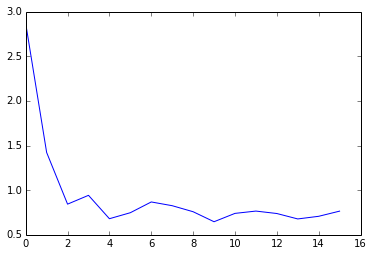

In [11]:
model.train(train_dataset,train_labels,batch_sz=128,epochs=1)